# Multi Layer Perceptron Model

- BOOK: [Predict the Future with MLPs, CNNs and LSTMs in Python](https://machinelearningmastery.com/deep-learning-for-time-series-forecasting/) by Jason Brownlee
- NOTES: [TS -> ML split function](https://detraviousjbrinkley.notion.site/TS-ML-split-function-9ab51cbb49d244aa8b4ab434d009f8a7?pvs=4) by Detravious J.B. 
    - See for Forecast vs Prediction

In [1]:
import os
import sys
import torch

import numpy as np
import pandas as pd

import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm

# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to the system path
sys.path.append(os.path.join(notebook_dir, '../framework_for_time_series_data/tslearn/'))
from ml_models import MLP
from ts_models import EvaluationMetric

In [2]:
observations = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# Book's implementation

In [3]:
def split_sequence(sequence, n_steps_in, n_steps_out): 
    X, y = list(), list() 
    for i in range(len(sequence)): 
        # find the end of this pattern 
        end_ix = i + n_steps_in 
        out_end_ix = end_ix + n_steps_out 
        # check if we are beyond the sequence 
        if out_end_ix > len(sequence): 
            break
        # gather input and output parts of the pattern 
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix] 
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [4]:
X, y = split_sequence(observations, 3, 3)

In [5]:
X

array([[10, 20, 30],
       [20, 30, 40],
       [30, 40, 50],
       [40, 50, 60]])

In [6]:
y

array([[40, 50, 60],
       [50, 60, 70],
       [60, 70, 80],
       [70, 80, 90]])

# My implementation

In [7]:
def convert_uts_sequence_to_sml(uts_observations, prior_observations, forecasting_step):
    """Splits a given UTS into multiple input rows where each input row has a specified number of timestamps and the output is a single timestamp.
    
    Parameters:
    uts_observations -- 1D np array (of UTS data to transform to SML data with size  b rows/length x 1 dimension)
    prior_observations -- py int (of all observations before we get to where we want to start making the predictions)
    forecasting_step -- py int (of how far out to forecast, 1 only the next timestamp, 2 the next two timestamps, ... n the next n timestamps)
    
    Return:
    agg.values -- np array (of new sml data)
    """
    
    df = pd.DataFrame(uts_observations)
    cols = list()
    
    lag_col_names = []
    count_lag = 0
    # input sequence (t-n, ... t-1)
    for prior_observation in range(prior_observations, 0, -1):
        # print("prior_observation: ", prior_observation)
        cols.append(df.shift(prior_observation))
        new_col_name = "t - " + str(prior_observation)
        # print(new_col_name)
        lag_col_names.append(new_col_name)
        
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, forecasting_step):
        cols.append(df.shift(-i))
        # print(f"t + {i}")
        if i == 0:
            new_col_name = f"t"
        else:
            new_col_name = f"t + {i}"
        # print(new_col_name)
        lag_col_names.append(new_col_name)
        
        # put it all together
        uts_sml_df = pd.concat(cols, axis=1) 
        uts_sml_df.columns=[lag_col_names]
        # drop rows with NaN values
        uts_sml_df.dropna(inplace=True)
    
    # print(uts_sml_df)
    
    # colums to use to make prediction for last col
    X_train = uts_sml_df.iloc[:, 0: -1]
    
    # last column
    y_train = uts_sml_df.iloc[:, [-1]]
    return uts_sml_df

In [8]:
n_steps = 3
output_size = 2
converted_seq_df = convert_uts_sequence_to_sml(observations, n_steps, output_size)

In [9]:
converted_seq_df

,t - 3,t - 2,t - 1,t,t + 1
3,10.0,20.0,30.0,40,50.0
4,20.0,30.0,40.0,50,60.0
5,30.0,40.0,50.0,60,70.0
6,40.0,50.0,60.0,70,80.0
7,50.0,60.0,70.0,80,90.0


In [10]:
forecast_X_train_df = converted_seq_df.iloc[:, :n_steps]
forecast_X_train_df

,t - 3,t - 2,t - 1
3,10.0,20.0,30.0
4,20.0,30.0,40.0
5,30.0,40.0,50.0
6,40.0,50.0,60.0
7,50.0,60.0,70.0


In [11]:
forecast_y_train_df = converted_seq_df.iloc[:, -output_size:]
forecast_y_train_df

,t,t + 1
3,40,50.0
4,50,60.0
5,60,70.0
6,70,80.0
7,80,90.0


In [12]:
forecast_X_test_df = converted_seq_df.iloc[[-1], -n_steps:]
forecast_X_test_df

,t - 1,t,t + 1
7,70.0,80,90.0


In [13]:
predict_X_train_df = converted_seq_df.iloc[:-1, :n_steps]
predict_X_train_df

,t - 3,t - 2,t - 1
3,10.0,20.0,30.0
4,20.0,30.0,40.0
5,30.0,40.0,50.0
6,40.0,50.0,60.0


In [14]:
predict_y_train_df = converted_seq_df.iloc[:-1, -output_size:]
predict_y_train_df

,t,t + 1
3,40,50.0
4,50,60.0
5,60,70.0
6,70,80.0


In [15]:
predict_X_test_df = converted_seq_df.iloc[[-n_steps], -n_steps:]
predict_X_test_df

,t - 1,t,t + 1
5,50.0,60,70.0


In [16]:
predict_y_test_df = converted_seq_df.iloc[[-1], -output_size:]
predict_y_test_df

,t,t + 1
7,80,90.0


# Book's implementation
- Keras

## Forecast model

In [17]:
from keras.models import Sequential 
from keras.layers import Dense

forecast_model = Sequential() 
forecast_model.add(Dense(100, activation='relu' , input_dim=n_steps)) 
forecast_model.add(Dense(output_size)) 
forecast_model.compile(optimizer='adam' , loss='mse') 

predict_model = Sequential() 
predict_model.add(Dense(100, activation='relu' , input_dim=n_steps)) 
predict_model.add(Dense(output_size)) 
predict_model.compile(optimizer='adam' , loss='mse') 

2024-07-13 19:26:51.304405: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-13 19:26:58.971041: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
# fit model 
forecast_model.fit(forecast_X_train_df, forecast_y_train_df, epochs=2000, verbose=0)

In [19]:
forecast_X_test = np.array(forecast_X_test_df)
forecast_X_test, forecast_X_test.shape[0]

(array([[70., 80., 90.]]), 1)

In [20]:
X_test = forecast_X_test.reshape((forecast_X_test.shape[0]), n_steps)
X_test

array([[70., 80., 90.]])

In [21]:
forecasts = forecast_model.predict(X_test, verbose=0)
forecasts

array([[104.40981, 115.59957]], dtype=float32)

## Predict model

In [22]:
predict_model.fit(predict_X_train_df, predict_y_train_df, epochs=20, verbose=0)

In [23]:
predict_X_test = np.array(predict_X_test_df)
predict_X_test, predict_X_test.shape[0]

(array([[50., 60., 70.]]), 1)

In [24]:
predict_X_test = forecast_X_test.reshape((predict_X_test.shape[0]), n_steps)
predict_X_test

array([[70., 80., 90.]])

In [25]:
book_model_predictions = predict_model.predict(predict_X_test, verbose=0)
book_model_predictions

array([[25.472755, 45.740124]], dtype=float32)

In [26]:
predict_y_test_df

,t,t + 1
7,80,90.0


In [27]:
EvaluationMetric.eval_mse(predict_y_test_df, book_model_predictions, False)

Test MSE: 2466.079


## My implementation

- Using my TSLearn library

### Prediction model

- Interpolation of in sample values 
- Use `50, 60, 70`, so X_test
- True predictions `80, 90`, so y_test

### Forecast model

- Extrapolation of future values `
- Use `70, 80, 90`, so X_test
- Expected `100, 110`. We say expected because we don't know the actual values, thus no y_test. Expected as in we increment by 10.

In [28]:
hidden_size = 100

mlp_predict_model = MLP(n_steps, hidden_size, output_size)
mlp_predict_model

MLP(
  (fc1): Linear(in_features=3, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [29]:
mlp_forecast_model = MLP(n_steps, hidden_size, output_size)
mlp_forecast_model

MLP(
  (fc1): Linear(in_features=3, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [33]:
forecast_X_train_df

,t - 3,t - 2,t - 1
3,10.0,20.0,30.0
4,20.0,30.0,40.0
5,30.0,40.0,50.0
6,40.0,50.0,60.0
7,50.0,60.0,70.0


In [30]:
# #times to loop through the training
# Hyperparameter
epochs = 2000
criterion = nn.MSELoss()

predict_optimizer = torch.optim.Adam(mlp_predict_model.parameters())
predict_configs = [criterion, predict_optimizer]

forecast_optimizer = torch.optim.Adam(mlp_forecast_model.parameters())
forecast_configs = [criterion, forecast_optimizer]

# Track different setups (ie: lr, etc) to compare this experiment to future experiments
epoch_count = []
train_pred_values = []
test_pred_values = []

predict_train_loss_values = []
predict_test_loss_values = []

forecast_train_loss_values = []
forecast_test_loss_values = []

### Training
# 0. Loop through the training
for epoch in tqdm(range(epochs)):

    # In-Sample Prediction
    train_predictions, predict_train_loss = mlp_predict_model.train_model(predict_X_train_df, predict_y_train_df, predict_configs)
    test_predictions, predict_test_loss = mlp_predict_model.interpolate_predictions(predict_X_test_df, predict_y_test_df, predict_configs)
    
    # Out-Sample Forecasts
    train_forecasts, forecast_train_loss = mlp_forecast_model.train_model(forecast_X_train_df, forecast_y_train_df, forecast_configs)
    test_forecasts = mlp_forecast_model.extrapolate_forecasts(forecast_X_test_df)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        print(f"Epoch: {epoch}")

        print(f"    Predictions | Train loss: {predict_train_loss} | Test loss: {predict_test_loss}")
        # print(f"    Predictions Parameters: {mlp_predict_model.state_dict()}")
        predict_train_loss_values.append(predict_train_loss)
        predict_test_loss_values.append(predict_test_loss)

        print(f"    Forecasts | Train loss: {forecast_train_loss}")
        # print(f"    Forecasts Parameters: {mlp_forecast_model.state_dict()}")
        forecast_train_loss_values.append(forecast_train_loss)
        # print()

  2%|▏         | 41/2000 [00:00<00:28, 67.90it/s]

Epoch: 0
    Predictions | Train loss: 4074.6533203125 | Test loss: 7711.736328125
    Forecasts | Train loss: 4184.96533203125
Epoch: 10
    Predictions | Train loss: 2750.412841796875 | Test loss: 4833.4306640625
    Forecasts | Train loss: 2617.53759765625
Epoch: 20
    Predictions | Train loss: 1705.462890625 | Test loss: 2662.55908203125
    Forecasts | Train loss: 1431.9300537109375
Epoch: 30
    Predictions | Train loss: 932.5897216796875 | Test loss: 1178.873046875
    Forecasts | Train loss: 640.198974609375
Epoch: 40
    Predictions | Train loss: 424.52294921875 | Test loss: 345.60784912109375
    Forecasts | Train loss: 217.2648468017578
Epoch: 50
    Predictions | Train loss: 156.12008666992188 | Test loss: 41.828922271728516
    Forecasts | Train loss: 70.5641860961914
Epoch: 60
    Predictions | Train loss: 59.31127166748047 | Test loss: 61.111392974853516
    Forecasts | Train loss: 53.9788932800293
Epoch: 70
    Predictions | Train loss: 40.821510314941406 | Test loss: 

  8%|▊         | 163/2000 [00:01<00:07, 240.07it/s]

Epoch: 90
    Predictions | Train loss: 37.87683868408203 | Test loss: 169.25387573242188
    Forecasts | Train loss: 49.59619140625
Epoch: 100
    Predictions | Train loss: 36.436973571777344 | Test loss: 142.86160278320312
    Forecasts | Train loss: 48.0103874206543
Epoch: 110
    Predictions | Train loss: 35.4530029296875 | Test loss: 124.86209106445312
    Forecasts | Train loss: 46.95061492919922
Epoch: 120
    Predictions | Train loss: 34.63003158569336 | Test loss: 117.28349304199219
    Forecasts | Train loss: 45.82170867919922
Epoch: 130
    Predictions | Train loss: 33.79766082763672 | Test loss: 115.53352355957031
    Forecasts | Train loss: 44.69575119018555
Epoch: 140
    Predictions | Train loss: 32.89731216430664 | Test loss: 114.94806671142578
    Forecasts | Train loss: 43.56767654418945
Epoch: 150
    Predictions | Train loss: 31.886093139648438 | Test loss: 113.35980224609375
    Forecasts | Train loss: 42.42289733886719
Epoch: 160
    Predictions | Train loss: 30.7

 12%|█▏        | 242/2000 [00:01<00:05, 308.20it/s]

Epoch: 180
    Predictions | Train loss: 28.793899536132812 | Test loss: 102.15785217285156
    Forecasts | Train loss: 38.92212677001953
Epoch: 190
    Predictions | Train loss: 27.825899124145508 | Test loss: 97.94282531738281
    Forecasts | Train loss: 37.73595428466797
Epoch: 200
    Predictions | Train loss: 26.853010177612305 | Test loss: 94.63165283203125
    Forecasts | Train loss: 36.552276611328125
Epoch: 210
    Predictions | Train loss: 25.87710189819336 | Test loss: 92.06838989257812
    Forecasts | Train loss: 35.364967346191406
Epoch: 220
    Predictions | Train loss: 24.899633407592773 | Test loss: 89.8353500366211
    Forecasts | Train loss: 34.174190521240234
Epoch: 230
    Predictions | Train loss: 23.932926177978516 | Test loss: 87.58013916015625
    Forecasts | Train loss: 32.98933029174805
Epoch: 240
    Predictions | Train loss: 22.966880798339844 | Test loss: 84.68968200683594
    Forecasts | Train loss: 31.802066802978516
Epoch: 250
    Predictions | Train los

 16%|█▌        | 323/2000 [00:01<00:04, 351.99it/s]

Epoch: 260
    Predictions | Train loss: 21.058284759521484 | Test loss: 78.17987060546875
    Forecasts | Train loss: 29.470529556274414
Epoch: 270
    Predictions | Train loss: 20.11330795288086 | Test loss: 75.32443237304688
    Forecasts | Train loss: 28.31842041015625
Epoch: 280
    Predictions | Train loss: 19.181358337402344 | Test loss: 72.55296325683594
    Forecasts | Train loss: 27.179141998291016
Epoch: 290
    Predictions | Train loss: 18.258710861206055 | Test loss: 69.65547180175781
    Forecasts | Train loss: 26.053409576416016
Epoch: 300
    Predictions | Train loss: 17.35027503967285 | Test loss: 66.74482727050781
    Forecasts | Train loss: 24.944257736206055
Epoch: 310
    Predictions | Train loss: 16.455774307250977 | Test loss: 63.84687042236328
    Forecasts | Train loss: 23.839412689208984
Epoch: 320
    Predictions | Train loss: 15.577291488647461 | Test loss: 61.00595474243164
    Forecasts | Train loss: 22.757137298583984
Epoch: 330
    Predictions | Train lo

 20%|██        | 405/2000 [00:01<00:04, 375.85it/s]

Epoch: 350
    Predictions | Train loss: 13.064631462097168 | Test loss: 52.86140441894531
    Forecasts | Train loss: 19.625513076782227
Epoch: 360
    Predictions | Train loss: 12.269533157348633 | Test loss: 50.235816955566406
    Forecasts | Train loss: 18.62664031982422
Epoch: 370
    Predictions | Train loss: 11.499849319458008 | Test loss: 47.753570556640625
    Forecasts | Train loss: 17.653675079345703
Epoch: 380
    Predictions | Train loss: 10.758404731750488 | Test loss: 45.30643844604492
    Forecasts | Train loss: 16.698932647705078
Epoch: 390
    Predictions | Train loss: 10.041655540466309 | Test loss: 42.9370231628418
    Forecasts | Train loss: 15.779154777526855
Epoch: 400
    Predictions | Train loss: 9.351503372192383 | Test loss: 40.62732696533203
    Forecasts | Train loss: 14.880027770996094
Epoch: 410
    Predictions | Train loss: 8.6897554397583 | Test loss: 38.30636978149414
    Forecasts | Train loss: 14.012855529785156
Epoch: 420
    Predictions | Train los

 24%|██▍       | 485/2000 [00:01<00:03, 385.53it/s]

Epoch: 440
    Predictions | Train loss: 6.879201889038086 | Test loss: 32.14448165893555
    Forecasts | Train loss: 11.586977005004883
Epoch: 450
    Predictions | Train loss: 6.336297988891602 | Test loss: 30.30518341064453
    Forecasts | Train loss: 10.834024429321289
Epoch: 460
    Predictions | Train loss: 5.820835590362549 | Test loss: 28.525060653686523
    Forecasts | Train loss: 10.119241714477539
Epoch: 470
    Predictions | Train loss: 5.334562301635742 | Test loss: 26.74346923828125
    Forecasts | Train loss: 9.436281204223633
Epoch: 480
    Predictions | Train loss: 4.8796067237854 | Test loss: 25.12923812866211
    Forecasts | Train loss: 8.77613353729248
Epoch: 490
    Predictions | Train loss: 4.4505510330200195 | Test loss: 23.587554931640625
    Forecasts | Train loss: 8.148921966552734
Epoch: 500
    Predictions | Train loss: 4.050883769989014 | Test loss: 22.104421615600586
    Forecasts | Train loss: 7.55746603012085
Epoch: 510
    Predictions | Train loss: 3.67

 30%|███       | 609/2000 [00:02<00:03, 402.23it/s]

Epoch: 530
    Predictions | Train loss: 3.0120530128479004 | Test loss: 18.90679931640625
    Forecasts | Train loss: 5.9579596519470215
Epoch: 540
    Predictions | Train loss: 2.716090202331543 | Test loss: 18.021020889282227
    Forecasts | Train loss: 5.487274646759033
Epoch: 550
    Predictions | Train loss: 2.4428882598876953 | Test loss: 17.10931396484375
    Forecasts | Train loss: 5.040675163269043
Epoch: 560
    Predictions | Train loss: 2.193622589111328 | Test loss: 16.381338119506836
    Forecasts | Train loss: 4.627192497253418
Epoch: 570
    Predictions | Train loss: 1.9659159183502197 | Test loss: 15.587031364440918
    Forecasts | Train loss: 4.244229316711426
Epoch: 580
    Predictions | Train loss: 1.7552858591079712 | Test loss: 14.896323204040527
    Forecasts | Train loss: 3.8931422233581543
Epoch: 590
    Predictions | Train loss: 1.5648865699768066 | Test loss: 14.2518892288208
    Forecasts | Train loss: 3.562903881072998
Epoch: 600
    Predictions | Train los

 35%|███▍      | 692/2000 [00:02<00:03, 405.90it/s]

Epoch: 620
    Predictions | Train loss: 1.095155119895935 | Test loss: 12.45294189453125
    Forecasts | Train loss: 2.7127785682678223
Epoch: 630
    Predictions | Train loss: 0.9689192175865173 | Test loss: 11.967727661132812
    Forecasts | Train loss: 2.4684863090515137
Epoch: 640
    Predictions | Train loss: 0.8546534180641174 | Test loss: 11.493032455444336
    Forecasts | Train loss: 2.2459053993225098
Epoch: 650
    Predictions | Train loss: 0.7530642747879028 | Test loss: 11.0466947555542
    Forecasts | Train loss: 2.038877010345459
Epoch: 660
    Predictions | Train loss: 0.6621354222297668 | Test loss: 10.65091323852539
    Forecasts | Train loss: 1.8505827188491821
Epoch: 670
    Predictions | Train loss: 0.5809521675109863 | Test loss: 10.225737571716309
    Forecasts | Train loss: 1.6757137775421143
Epoch: 680
    Predictions | Train loss: 0.509249746799469 | Test loss: 9.92406940460205
    Forecasts | Train loss: 1.5154063701629639
Epoch: 690
    Predictions | Train l

 39%|███▊      | 774/2000 [00:02<00:03, 407.31it/s]

Epoch: 710
    Predictions | Train loss: 0.33915892243385315 | Test loss: 8.97273063659668
    Forecasts | Train loss: 1.115315556526184
Epoch: 720
    Predictions | Train loss: 0.2951684296131134 | Test loss: 8.696636199951172
    Forecasts | Train loss: 1.0052847862243652
Epoch: 730
    Predictions | Train loss: 0.2566041350364685 | Test loss: 8.422572135925293
    Forecasts | Train loss: 0.9044865369796753
Epoch: 740
    Predictions | Train loss: 0.22282731533050537 | Test loss: 8.212607383728027
    Forecasts | Train loss: 0.8132799863815308
Epoch: 750
    Predictions | Train loss: 0.1932133138179779 | Test loss: 7.996518611907959
    Forecasts | Train loss: 0.7298198342323303
Epoch: 760
    Predictions | Train loss: 0.1674254834651947 | Test loss: 7.820624351501465
    Forecasts | Train loss: 0.6548075675964355
Epoch: 770
    Predictions | Train loss: 0.14477409422397614 | Test loss: 7.660475730895996
    Forecasts | Train loss: 0.5856426954269409
Epoch: 780
    Predictions | Trai

 43%|████▎     | 857/2000 [00:02<00:02, 410.65it/s]

Epoch: 800
    Predictions | Train loss: 0.09300696104764938 | Test loss: 7.2221479415893555
    Forecasts | Train loss: 0.41712966561317444
Epoch: 810
    Predictions | Train loss: 0.08001087605953217 | Test loss: 7.107242584228516
    Forecasts | Train loss: 0.371108740568161
Epoch: 820
    Predictions | Train loss: 0.06882023066282272 | Test loss: 7.001659393310547
    Forecasts | Train loss: 0.32996755838394165
Epoch: 830
    Predictions | Train loss: 0.05913206934928894 | Test loss: 6.9016523361206055
    Forecasts | Train loss: 0.2928878664970398
Epoch: 840
    Predictions | Train loss: 0.0507204569876194 | Test loss: 6.809441566467285
    Forecasts | Train loss: 0.25985196232795715
Epoch: 850
    Predictions | Train loss: 0.043491117656230927 | Test loss: 6.724126815795898
    Forecasts | Train loss: 0.23005786538124084
Epoch: 860
    Predictions | Train loss: 0.0372748002409935 | Test loss: 6.649641513824463
    Forecasts | Train loss: 0.20340001583099365
Epoch: 870
    Predict

 47%|████▋     | 940/2000 [00:03<00:02, 408.66it/s]

Epoch: 890
    Predictions | Train loss: 0.02332872711122036 | Test loss: 6.449029922485352
    Forecasts | Train loss: 0.13948151469230652
Epoch: 900
    Predictions | Train loss: 0.019942570477724075 | Test loss: 6.398982524871826
    Forecasts | Train loss: 0.12263122946023941
Epoch: 910
    Predictions | Train loss: 0.017030073329806328 | Test loss: 6.348197937011719
    Forecasts | Train loss: 0.10764239728450775
Epoch: 920
    Predictions | Train loss: 0.014550662599503994 | Test loss: 6.300602912902832
    Forecasts | Train loss: 0.09440206736326218
Epoch: 930
    Predictions | Train loss: 0.012415408156812191 | Test loss: 6.2604265213012695
    Forecasts | Train loss: 0.08270169794559479
Epoch: 940
    Predictions | Train loss: 0.010602863505482674 | Test loss: 6.223752498626709
    Forecasts | Train loss: 0.07230361551046371
Epoch: 950
    Predictions | Train loss: 0.009056927636265755 | Test loss: 6.191226005554199
    Forecasts | Train loss: 0.06313695758581161
Epoch: 960
  

 51%|█████     | 1022/2000 [00:03<00:02, 408.49it/s]

Epoch: 980
    Predictions | Train loss: 0.005669281352311373 | Test loss: 6.104325294494629
    Forecasts | Train loss: 0.041715703904628754
Epoch: 990
    Predictions | Train loss: 0.0048613036051392555 | Test loss: 6.080780506134033
    Forecasts | Train loss: 0.036258965730667114
Epoch: 1000
    Predictions | Train loss: 0.004177028778940439 | Test loss: 6.059504508972168
    Forecasts | Train loss: 0.031443726271390915
Epoch: 1010
    Predictions | Train loss: 0.0035983461420983076 | Test loss: 6.039910316467285
    Forecasts | Train loss: 0.027257520705461502
Epoch: 1020
    Predictions | Train loss: 0.0031090148258954287 | Test loss: 6.0231218338012695
    Forecasts | Train loss: 0.02358308434486389
Epoch: 1030
    Predictions | Train loss: 0.002694894792512059 | Test loss: 6.0078630447387695
    Forecasts | Train loss: 0.020383309572935104
Epoch: 1040
    Predictions | Train loss: 0.0023461878299713135 | Test loss: 5.992048263549805
    Forecasts | Train loss: 0.017583144828677

 57%|█████▋    | 1146/2000 [00:03<00:02, 407.14it/s]

Epoch: 1070
    Predictions | Train loss: 0.0015958592994138598 | Test loss: 5.957634925842285
    Forecasts | Train loss: 0.01120575051754713
Epoch: 1080
    Predictions | Train loss: 0.0014193679671734571 | Test loss: 5.948855400085449
    Forecasts | Train loss: 0.009619029238820076
Epoch: 1090
    Predictions | Train loss: 0.0012691458687186241 | Test loss: 5.942605018615723
    Forecasts | Train loss: 0.008248626254498959
Epoch: 1100
    Predictions | Train loss: 0.0011405679397284985 | Test loss: 5.93868350982666
    Forecasts | Train loss: 0.007057602517306805
Epoch: 1110
    Predictions | Train loss: 0.0010294041130691767 | Test loss: 5.936458587646484
    Forecasts | Train loss: 0.006029700394719839
Epoch: 1120
    Predictions | Train loss: 0.000933003262616694 | Test loss: 5.936595916748047
    Forecasts | Train loss: 0.005146989598870277
Epoch: 1130
    Predictions | Train loss: 0.0008493338245898485 | Test loss: 5.936818599700928
    Forecasts | Train loss: 0.00439061690121

 61%|██████▏   | 1229/2000 [00:03<00:01, 408.27it/s]

Epoch: 1160
    Predictions | Train loss: 0.0006591663113795221 | Test loss: 5.93616247177124
    Forecasts | Train loss: 0.0026944486889988184
Epoch: 1170
    Predictions | Train loss: 0.0006116688018664718 | Test loss: 5.935698509216309
    Forecasts | Train loss: 0.002285757102072239
Epoch: 1180
    Predictions | Train loss: 0.0005703240167349577 | Test loss: 5.935351371765137
    Forecasts | Train loss: 0.0019339567515999079
Epoch: 1190
    Predictions | Train loss: 0.0005352357402443886 | Test loss: 5.93507194519043
    Forecasts | Train loss: 0.0016340201254934072
Epoch: 1200
    Predictions | Train loss: 0.0005053299246355891 | Test loss: 5.934911727905273
    Forecasts | Train loss: 0.0013795619597658515
Epoch: 1210
    Predictions | Train loss: 0.00047914942842908204 | Test loss: 5.934785842895508
    Forecasts | Train loss: 0.001163734938018024
Epoch: 1220
    Predictions | Train loss: 0.0004563144175335765 | Test loss: 5.93453311920166
    Forecasts | Train loss: 0.000979290

 66%|██████▌   | 1311/2000 [00:03<00:01, 405.45it/s]

Epoch: 1250
    Predictions | Train loss: 0.00040339061524719 | Test loss: 5.933950424194336
    Forecasts | Train loss: 0.000579171406570822
Epoch: 1260
    Predictions | Train loss: 0.0003899651928804815 | Test loss: 5.933720588684082
    Forecasts | Train loss: 0.00048476867959834635
Epoch: 1270
    Predictions | Train loss: 0.00037817913107573986 | Test loss: 5.933579921722412
    Forecasts | Train loss: 0.00040509141399525106
Epoch: 1280
    Predictions | Train loss: 0.0003679503861349076 | Test loss: 5.933420181274414
    Forecasts | Train loss: 0.00033816759241744876
Epoch: 1290
    Predictions | Train loss: 0.0003589948173612356 | Test loss: 5.933233261108398
    Forecasts | Train loss: 0.00028178669163025916
Epoch: 1300
    Predictions | Train loss: 0.0003511955146677792 | Test loss: 5.933110237121582
    Forecasts | Train loss: 0.0002346094261156395
Epoch: 1310
    Predictions | Train loss: 0.0003443524765316397 | Test loss: 5.932926177978516
    Forecasts | Train loss: 0.000

 70%|██████▉   | 1394/2000 [00:04<00:01, 408.38it/s]

Epoch: 1340
    Predictions | Train loss: 0.0003285820712335408 | Test loss: 5.9325337409973145
    Forecasts | Train loss: 0.00011094407818745822
Epoch: 1350
    Predictions | Train loss: 0.0003246006090193987 | Test loss: 5.932424545288086
    Forecasts | Train loss: 9.168779070023447e-05
Epoch: 1360
    Predictions | Train loss: 0.00032119167735800147 | Test loss: 5.93230676651001
    Forecasts | Train loss: 7.564318366348743e-05
Epoch: 1370
    Predictions | Train loss: 0.00031805821345187724 | Test loss: 5.932186126708984
    Forecasts | Train loss: 6.229421705938876e-05
Epoch: 1380
    Predictions | Train loss: 0.0003154592704959214 | Test loss: 5.932074069976807
    Forecasts | Train loss: 5.1260147301945835e-05
Epoch: 1390
    Predictions | Train loss: 0.000313091732095927 | Test loss: 5.931970596313477
    Forecasts | Train loss: 4.2121042497456074e-05
Epoch: 1400
    Predictions | Train loss: 0.0003110873803962022 | Test loss: 5.931884765625
    Forecasts | Train loss: 3.4544

 74%|███████▍  | 1477/2000 [00:04<00:01, 402.98it/s]

Epoch: 1430
    Predictions | Train loss: 0.0003062931355088949 | Test loss: 5.931574821472168
    Forecasts | Train loss: 1.8892387743107975e-05
Epoch: 1440
    Predictions | Train loss: 0.0003050354134757072 | Test loss: 5.931465148925781
    Forecasts | Train loss: 1.5428478945977986e-05
Epoch: 1450
    Predictions | Train loss: 0.00030388531740754843 | Test loss: 5.9313764572143555
    Forecasts | Train loss: 1.2547288861242123e-05
Epoch: 1460
    Predictions | Train loss: 0.0003029317012988031 | Test loss: 5.931239128112793
    Forecasts | Train loss: 1.0188179658143781e-05
Epoch: 1470
    Predictions | Train loss: 0.00030210596742108464 | Test loss: 5.931224822998047
    Forecasts | Train loss: 8.287621312774718e-06
Epoch: 1480
    Predictions | Train loss: 0.00030126533238217235 | Test loss: 5.931112289428711
    Forecasts | Train loss: 6.708863566018408e-06
Epoch: 1490
    Predictions | Train loss: 0.0003005456237588078 | Test loss: 5.931065559387207
    Forecasts | Train loss:

 80%|████████  | 1602/2000 [00:04<00:00, 409.42it/s]

Epoch: 1520
    Predictions | Train loss: 0.0002988145570270717 | Test loss: 5.930814743041992
    Forecasts | Train loss: 2.8414972348400624e-06
Epoch: 1530
    Predictions | Train loss: 0.00029823422664776444 | Test loss: 5.930764675140381
    Forecasts | Train loss: 2.289096300955862e-06
Epoch: 1540
    Predictions | Train loss: 0.00029771641129627824 | Test loss: 5.930718421936035
    Forecasts | Train loss: 1.8381761037744582e-06
Epoch: 1550
    Predictions | Train loss: 0.0002972815418615937 | Test loss: 5.930667877197266
    Forecasts | Train loss: 1.4799850305280415e-06
Epoch: 1560
    Predictions | Train loss: 0.0002968228072859347 | Test loss: 5.930577278137207
    Forecasts | Train loss: 1.1780560953411623e-06
Epoch: 1570
    Predictions | Train loss: 0.0002964175946544856 | Test loss: 5.930515289306641
    Forecasts | Train loss: 9.407056609234132e-07
Epoch: 1580
    Predictions | Train loss: 0.00029605257441289723 | Test loss: 5.930403709411621
    Forecasts | Train loss: 

 84%|████████▍ | 1684/2000 [00:04<00:00, 408.17it/s]

Epoch: 1610
    Predictions | Train loss: 0.00029504921985790133 | Test loss: 5.930184364318848
    Forecasts | Train loss: 3.7972057498336653e-07
Epoch: 1620
    Predictions | Train loss: 0.00029465905390679836 | Test loss: 5.930118560791016
    Forecasts | Train loss: 3.0078081181272864e-07
Epoch: 1630
    Predictions | Train loss: 0.00029434970929287374 | Test loss: 5.930052757263184
    Forecasts | Train loss: 2.3737229071230104e-07
Epoch: 1640
    Predictions | Train loss: 0.0002939584373962134 | Test loss: 5.929908752441406
    Forecasts | Train loss: 1.895605237223208e-07
Epoch: 1650
    Predictions | Train loss: 0.0002936694072559476 | Test loss: 5.929867267608643
    Forecasts | Train loss: 1.5062104807839205e-07
Epoch: 1660
    Predictions | Train loss: 0.0002933517098426819 | Test loss: 5.929821968078613
    Forecasts | Train loss: 1.1768861440941691e-07
Epoch: 1670
    Predictions | Train loss: 0.0002930500195361674 | Test loss: 5.929739952087402
    Forecasts | Train loss:

 88%|████████▊ | 1767/2000 [00:05<00:00, 408.76it/s]

Epoch: 1700
    Predictions | Train loss: 0.0002921119157690555 | Test loss: 5.929443359375
    Forecasts | Train loss: 4.456815005937642e-08
Epoch: 1710
    Predictions | Train loss: 0.00029183353763073683 | Test loss: 5.9293904304504395
    Forecasts | Train loss: 3.5588165303579444e-08
Epoch: 1720
    Predictions | Train loss: 0.0002915197401307523 | Test loss: 5.929333209991455
    Forecasts | Train loss: 2.742599392036027e-08
Epoch: 1730
    Predictions | Train loss: 0.0002911713672801852 | Test loss: 5.92925500869751
    Forecasts | Train loss: 2.134911447626564e-08
Epoch: 1740
    Predictions | Train loss: 0.00029085107962600887 | Test loss: 5.929193496704102
    Forecasts | Train loss: 1.7006822616849604e-08
Epoch: 1750
    Predictions | Train loss: 0.00029053157777525485 | Test loss: 5.929119110107422
    Forecasts | Train loss: 1.3441604274078145e-08
Epoch: 1760
    Predictions | Train loss: 0.0002902705455198884 | Test loss: 5.929066181182861
    Forecasts | Train loss: 1.09

 92%|█████████▏| 1846/2000 [00:05<00:00, 365.29it/s]

Epoch: 1780
    Predictions | Train loss: 0.0002896349469665438 | Test loss: 5.9289140701293945
    Forecasts | Train loss: 6.670597851865523e-09
Epoch: 1790
    Predictions | Train loss: 0.00028927301173098385 | Test loss: 5.928824424743652
    Forecasts | Train loss: 4.997127600603335e-09
Epoch: 1800
    Predictions | Train loss: 0.0002889659663196653 | Test loss: 5.928713321685791
    Forecasts | Train loss: 4.160392474972241e-09
Epoch: 1810
    Predictions | Train loss: 0.00028868834488093853 | Test loss: 5.928635597229004
    Forecasts | Train loss: 3.3222022910450733e-09
Epoch: 1820
    Predictions | Train loss: 0.00028839107835665345 | Test loss: 5.928602695465088
    Forecasts | Train loss: 2.310844182673577e-09
Epoch: 1830
    Predictions | Train loss: 0.00028806066256947815 | Test loss: 5.928487777709961
    Forecasts | Train loss: 1.8393621070700306e-09
Epoch: 1840
    Predictions | Train loss: 0.00028776456019841135 | Test loss: 5.928380966186523
    Forecasts | Train loss:

 96%|█████████▋| 1929/2000 [00:05<00:00, 387.03it/s]

Epoch: 1860
    Predictions | Train loss: 0.0002870742173399776 | Test loss: 5.9282379150390625
    Forecasts | Train loss: 9.356881935929096e-10
Epoch: 1870
    Predictions | Train loss: 0.00028674627537839115 | Test loss: 5.928168296813965
    Forecasts | Train loss: 7.392372824988058e-10
Epoch: 1880
    Predictions | Train loss: 0.00028645165730267763 | Test loss: 5.928094387054443
    Forecasts | Train loss: 6.970367616432327e-10
Epoch: 1890
    Predictions | Train loss: 0.0002861756656784564 | Test loss: 5.928024768829346
    Forecasts | Train loss: 6.344634817523342e-10
Epoch: 1900
    Predictions | Train loss: 0.00028577892226167023 | Test loss: 5.927955627441406
    Forecasts | Train loss: 6.344634817523342e-10
Epoch: 1910
    Predictions | Train loss: 0.0002854835183825344 | Test loss: 5.927881240844727
    Forecasts | Train loss: 5.937181302151373e-10
Epoch: 1920
    Predictions | Train loss: 0.000285144429653883 | Test loss: 5.927828311920166
    Forecasts | Train loss: 5.67

100%|██████████| 2000/2000 [00:05<00:00, 350.69it/s]

Epoch: 1950
    Predictions | Train loss: 0.0002841119421645999 | Test loss: 5.92763614654541
    Forecasts | Train loss: 5.384208634495735e-10
Epoch: 1960
    Predictions | Train loss: 0.00028382212622091174 | Test loss: 5.927603244781494
    Forecasts | Train loss: 4.933099484460968e-10
Epoch: 1970
    Predictions | Train loss: 0.0002834461338352412 | Test loss: 5.927554130554199
    Forecasts | Train loss: 4.481989779314688e-10
Epoch: 1980
    Predictions | Train loss: 0.00028320151614025235 | Test loss: 5.927480220794678
    Forecasts | Train loss: 4.176399781563589e-10
Epoch: 1990
    Predictions | Train loss: 0.0002827921125572175 | Test loss: 5.927406311035156
    Forecasts | Train loss: 4.3364706270310194e-10


In [31]:
EvaluationMetric.eval_mse(predict_y_test_df, test_predictions, False) # Matches Test MSE

Test MSE: 5.927


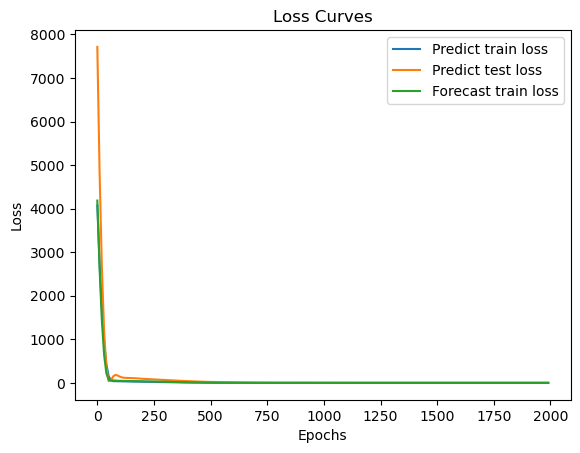

In [32]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(predict_train_loss_values).numpy()), label="Predict train loss")
plt.plot(epoch_count, predict_test_loss_values, label="Predict test loss")

plt.plot(epoch_count, np.array(torch.tensor(forecast_train_loss_values).numpy()), label="Forecast train loss")

plt.title("Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();